# This is a notebook for SVM, training a model to be able to categorize fake vs real news

In [1]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Make a function to apply text preprocesing to the datasets. </br>
Load the data formating it correctly for easy use and apply the preporcessing </br>
Split the data into a label and title columns so es easy to access only the title for training

In [2]:
stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    cleaned = []
    for token in tokens:
        token = re.sub(r'[^\w\s]', '', token)  # Remove punctuation
        token = re.sub(r'\d+', '', token)
        if token.isalpha() and token not in stop_words:  # Keep only words (no numbers/special chars)
            cleaned.append(token)
    return cleaned

In [3]:
# Load the datasets formating them correctly for ease of use
train_data = pd.read_csv(
    r"../training_data_lowercase.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

test_data = pd.read_csv(
    r"../testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB separator
    header=None,
    names=['label', 'title']
)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [4]:
# Tokenize train and testing data
def tokenizeDataframe(text):
    tokens = word_tokenize(text)
    return tokens

# train_data['title'] = train_data['title'].apply(tokenizeDataframe)
# test_data['title'] = test_data['title'].apply(tokenizeDataframe)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [5]:
# Apply preprocessing to the 'title' column
# train_data['title'] = train_data['title'].apply(clean_tokens)
# test_data['title'] = test_data['title'].apply(clean_tokens)

print(train_data['title'].head())
print(test_data['title'].head())

0    donald trump sends out embarrassing new year‚s...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes an internet joke ...
3    trump is so obsessed he even has obama‚s name ...
4    pope francis just called out donald trump duri...
Name: title, dtype: object
0    copycat muslim terrorist arrested with assault...
1    wow! chicago protester caught on camera admits...
2     germany's fdp look to fill schaeuble's big shoes
3    mi school sends welcome back packet warning ki...
4    u.n. seeks 'massive' aid boost amid rohingya '...
Name: title, dtype: object


Tokenice and stemming to prepare the titles to convert to numbers using TF_IDF

In [6]:
# stemming for simplifying the words
stemmer = PorterStemmer()
# train_data['title'] = train_data['title'].apply(lambda title: [stemmer.stem(word) for word in title])
# test_data['title'] = test_data['title'].apply(lambda title: [stemmer.stem(word) for word in title])

print("Stemmed Tokens:", train_data['title'].head())
print("Stemmed Tokens:", test_data['title'].head())

Stemmed Tokens: 0    donald trump sends out embarrassing new year‚s...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes an internet joke ...
3    trump is so obsessed he even has obama‚s name ...
4    pope francis just called out donald trump duri...
Name: title, dtype: object
Stemmed Tokens: 0    copycat muslim terrorist arrested with assault...
1    wow! chicago protester caught on camera admits...
2     germany's fdp look to fill schaeuble's big shoes
3    mi school sends welcome back packet warning ki...
4    u.n. seeks 'massive' aid boost amid rohingya '...
Name: title, dtype: object


Apply TF-IDF to the dataset to conver the words into numerical values for model training

In [7]:
# Join tokenized words back into strings
# train_data['title'] = train_data['title'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(train_data['title'])

print("\nTF-IDF Feature Names:", tfidf_vectorizer.get_feature_names_out())
print("\nTF-IDF Representation:\n", X_tfidf)


TF-IDF Feature Names: ['00' '0045' '0111' ... 'îk' 'îpence' 'øqu']

TF-IDF Representation:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 390264 stored elements and shape (34152, 18673)>
  Coords	Values
  (0, 5341)	0.23594607631008147
  (0, 17168)	0.09871680270440454
  (0, 14809)	0.360810448061762
  (0, 11760)	0.2251642878332491
  (0, 5782)	0.36784073721965305
  (0, 11261)	0.21081145630832848
  (0, 18556)	0.2795008715924424
  (0, 6110)	0.41238633616840253
  (0, 10595)	0.31514400469546994
  (0, 16720)	0.22142744799533873
  (0, 9017)	0.18273121389310565
  (0, 5242)	0.3795171214730221
  (1, 17168)	0.10035834003226096
  (1, 5514)	0.4328255787960555
  (1, 2371)	0.42168063909640197
  (1, 15785)	0.3923235418466126
  (1, 15837)	0.3982062340521523
  (1, 14360)	0.26389760407113516
  (1, 3525)	0.38008086220062226
  (1, 8953)	0.3133469115315427
  (2, 14997)	0.27978598468001187
  (2, 4445)	0.30178363237263756
  (2, 3325)	0.3361754376926148
  (2, 1830)	0.3090971771169678
  (2, 985)	

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, train_data['label'], test_size=0.2, random_state=42)

# Initialize the SVM model
svm_model = SVC(kernel='linear')  # You can choose other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

In [9]:
# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

# Calculate R²
r2 = r2_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Classification Report:\n", report_svm)
print(f"R²: {r2}")

SVM Accuracy: 0.9484702093397746
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      3529
           1       0.94      0.96      0.95      3302

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831

R²: 0.7936529703955064


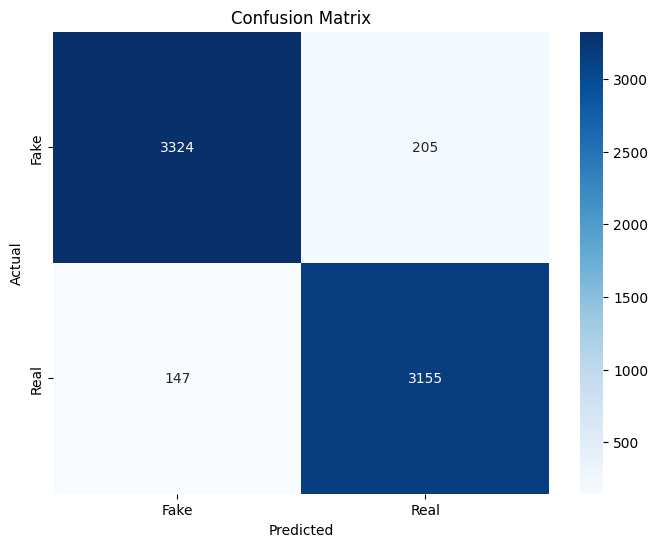

In [10]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Predict labels for the testing data and write them on a csv file

In [11]:
X_test_unlabeled = tfidf_vectorizer.transform(test_data['title'].apply(lambda tokens: ' '.join(tokens)))

# Predict labels for the unlabeled data
predicted_labels = svm_model.predict(X_test_unlabeled)

test_data['label'] = predicted_labels

# Display the first few rows of the updated testing data
print(test_data.head())

   label                                              title
0      1  copycat muslim terrorist arrested with assault...
1      1  wow! chicago protester caught on camera admits...
2      1   germany's fdp look to fill schaeuble's big shoes
3      1  mi school sends welcome back packet warning ki...
4      1  u.n. seeks 'massive' aid boost amid rohingya '...


In [12]:
# Make sure title is string, not list
test_data['title'] = test_data['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Export respecting original format
test_data[['label', 'title']].to_csv(
    r'svm_test_data.csv',
    sep='\t',  # TAB separator
    index=False,
    header=False  # No column names
)
print("\n:white_check_mark: Predictions exported successfully in correct format!")


:white_check_mark: Predictions exported successfully in correct format!
